In [1]:
# import statements
import pandas as pdtn_county_map
import numpy as np
import requests
#from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
import matplotlib.pyplot as plt
#import seaborn as sns
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
#import cartopy
#import cartopy.io.shapereader as shapereader
#from cartopy.io import shapereader
%matplotlib inline
# import io
# import scipy.stats as stats
# import statsmodels.api as sm

#Note - had to # out cartopy due to error

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Create a base map for the state of TN, broken down by county.**

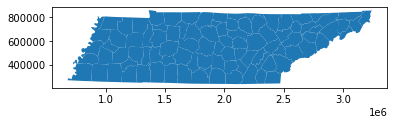

In [3]:
# read in tn county.shp file
tn_county_map = gpd.read_file('../maps/tncounty.shp')
tn_county_map.plot();

In [4]:
# Take a look at the base map dataframe
tn_county_map.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [5]:
# Check to make sure nothing is missing
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [6]:
# check the projection type
tn_county_map.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
# change the projection type
tn_county_map = tn_county_map.to_crs('EPSG:4326')
print(tn_county_map.crs)
# Make sure the base map dataset is good to go
tn_county_map.head(2)

EPSG:4326


,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((-88.78177 35.24759, -88.78185 35.247..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((-88.02474 35.39231, -88.02237 35.390..."


# Pull in shake probability file 


In [8]:
shake_prob = pd.read_csv('../maps/ProbMMI_VI_100Yrs_VariableVs30.csv')
shake_prob.head()

,lon,lat,PctProb100yrs
0,-125.0,50.0,30.27
1,-124.9,50.0,29.00
2,-124.8,50.0,35.98
3,-124.7,50.0,24.64
4,-124.6,50.0,27.86


In [9]:
shake_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156861 entries, 0 to 156860
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lon            156861 non-null  float64
 1   lat            156861 non-null  float64
 2   PctProb100yrs  156861 non-null  float64
dtypes: float64(3)
memory usage: 3.6 MB


In [10]:
type(shake_prob)

pandas.core.frame.DataFrame

In [11]:
#create a geometry column
shake_prob['geometry'] = shake_prob.apply(lambda x: Point((float(x.lon),
                                            float(x.lat))),
                              axis = 1)
shake_prob.head()

,lon,lat,PctProb100yrs,geometry
0,-125.0,50.0,30.27,POINT (-125 50)
1,-124.9,50.0,29.00,POINT (-124.9 50)
2,-124.8,50.0,35.98,POINT (-124.8 50)
3,-124.7,50.0,24.64,POINT (-124.7 50)
4,-124.6,50.0,27.86,POINT (-124.6 50)


In [12]:
#turn shake_prob dframe into a geodframe
shake_prob_geo = gpd.GeoDataFrame(shake_prob,
                             crs = tn_county_map.crs,
                             geometry = shake_prob['geometry'])


In [13]:
type(shake_prob_geo)

geopandas.geodataframe.GeoDataFrame

In [14]:
# Join the shake_prob_geo data to the TN basemap
tn_shake_geo = gpd.sjoin(shake_prob_geo, tn_county_map, op = 'within')
tn_shake_geo.head()

,lon,lat,PctProb100yrs,geometry,index_right,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN
80904,-88.0,36.6,28.78,POINT (-88.00000 36.60000),4,80,Stewart,47161,1.375003e+10,490090.33618
80905,-87.9,36.6,27.82,POINT (-87.90000 36.60000),4,80,Stewart,47161,1.375003e+10,490090.33618
80906,-87.8,36.6,29.12,POINT (-87.80000 36.60000),4,80,Stewart,47161,1.375003e+10,490090.33618
80907,-87.7,36.6,29.44,POINT (-87.70000 36.60000),4,80,Stewart,47161,1.375003e+10,490090.33618
81505,-88.0,36.5,28.03,POINT (-88.00000 36.50000),4,80,Stewart,47161,1.375003e+10,490090.33618


In [15]:
tn_shake_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1105 entries, 80904 to 90556
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   lon            1105 non-null   float64 
 1   lat            1105 non-null   float64 
 2   PctProb100yrs  1105 non-null   float64 
 3   geometry       1105 non-null   geometry
 4   index_right    1105 non-null   int64   
 5   OBJECTID       1105 non-null   int64   
 6   NAME           1105 non-null   object  
 7   KEY            1105 non-null   object  
 8   SHAPE_AREA     1105 non-null   float64 
 9   SHAPE_LEN      1105 non-null   float64 
dtypes: float64(5), geometry(1), int64(2), object(2)
memory usage: 95.0+ KB


In [16]:
tn_shake_geo.to_csv('../data/tn_shake_geo.csv')

In [17]:
#change column names to spell out longitude, latitude and all lower case 
#tn_shake_geo = tn_shake_geo.rename(columns = {"lon":"longitude", "lat":"latitude", "PctProb100yrs":"pct_prob_100yrs"})
#tn_shake_geo = tn_shake_geo.columns.str.lower()
#tn_shake_geo


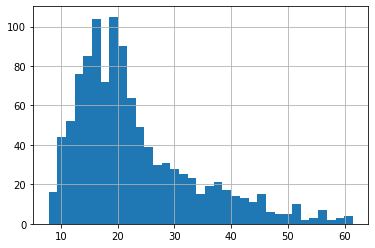

In [18]:
tn_shake_geo['PctProb100yrs'].hist(bins=35);

In [20]:
#tn_shake_geo.plot(kind = 'scatter', x = 'NAME', y = 'PctProb100yrs');

In [21]:
#get probability median & max per county
tn_shake_geo_prob = tn_shake_geo.groupby('NAME')['PctProb100yrs'].agg(['median','max'])
tn_shake_geo_prob.head()

,median,max
NAME,,
Anderson,16.68,23.48
Bedford,16.47,19.56
Benton,30.18,32.83
Bledsoe,18.31,24.48
Blount,23.80,30.84


In [ ]:
#sns.swarmplot(data = tn_shake_geo, x = 'NAME', y = 'PctProb100yrs');

In [22]:
# tn_shake_geo_prob['PctProb100yrs'].hist(bins=35);

KeyError: 'PctProb100yrs'

In [ ]:
#Export to csv file.  If you want to export without the index, add <,index=False> after .csv 
# tn_shake_geo_prob.to_csv('../data/tn_shake_geo_prob.csv')

In [ ]:
# .corr(method='pearson')